###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Relax and hold steady

Welcome to the second notebook of *Relax and hold steady: elliptic problems*, the fifth module of [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about).

The previous notebook introduced the Laplace equation, which is time-independent. To solve the resulting linear system, we used Jacobi iterations to *relax* an initial guess to the final solution. This notebook presents a slight modification. Now, the right hand side of the equation is not 0, but a forcing function that drives the solution: we present to you the **Poisson equation**.

## Poisson Equation

Poisson's equation is obtained by adding a source term to the right-hand-side of Laplace's equation:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

So, unlinke the Laplace equation, there is some finite value inside the field that affects the solution. 

In discretized form, this looks almost the same as [the Laplace Equation](2D_Laplace_Equation.ipynb), except for the source term:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

As before, we rearrange this so that we obtain an equation for $p$ at point $i,j$. Thus, we obtain:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

It's slightly more complicated than the Laplace equation, but nothing we can't handle.  

##An example problem

Let's consider the Poisson equation

\begin{equation}
\nabla^2 p = -2\left(\frac{\pi}{2}\right)^2\sin\left( \frac{\pi x}{L} \right) \cos\left(\frac{\pi y}{L}\right)
\end{equation}

in the domain 

$$\left\lbrace \begin{align*}
0 &\leq x\leq 1  \\
-0.5 &\leq y \leq 0.5 
\end{align*} \right.$$

with boundary conditions 

$$p=0 \text{ at } \left\lbrace 
\begin{align*}
x&=0\\
y&=0\\
y&=-0.5\\
y&=0.5
\end{align*} \right.$$

We will solve this equation by assuming an initial state of $p=0$ everywhere, and applying boundary conditions to relax in pseudo-time.

To start, let's import libraries and setup our mesh

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline

In [2]:
# Parameters
nx = 41
ny = 41
xmin = 0
xmax = 1
ymin = -0.5
ymax = 0.5


l2_target = 1e-10

def initialization(nx, ny, xmax, xmin, ymax, ymin):
    '''Initialization
    Parameters:
    ----------
    nx : int
        number of mesh points in x
    ny : int
        number of mesh points in y
    xmax: float
        maximum value of x in mesh
    xmin: float
        minimum value of x in mesh
    ymax: float
        maximum value of y in mesh
    ymin: float
        minimum value of y in mesh
    
    Returns:
    -------
    X  : 2D array of floats
        X-position of mesh
    Y  : 2D array of floats
        Y-position of mesh
    p_i: 2D array of floats
        initial guess of p
    b  : 2D array of floats
        forcing function
    dx : float
        mesh size in x direction
    dy : float
        mesh size in y direction
    '''

    dx = (xmax-xmin)/(nx-1)
    dy = (ymax-ymin)/(ny-1)

    # Mesh
    x  = numpy.linspace(xmin,xmax,nx)
    y  = numpy.linspace(ymin,ymax,ny)
    X,Y = numpy.meshgrid(x,y)

    # Source
    L = xmax-xmin
    b = -2*(pi/L)**2*numpy.sin(pi*X/L)*numpy.cos(pi*Y/L)

    # Initialization
    p_i  = numpy.zeros((ny,nx))

    return X, Y, x, y, p_i, b, dx, dy, L

Our Jacobi iterations need an exit condition. We can use the same relative L2 norm that we wrote for the Laplace exit condition.  We've dumped that function into a helper file for easy importing.  

In [3]:
from laplace_helper import L2_rel_error

Now to write the function to perform the iterative solve.  Notice that all of the boundaries in this problem are Dirichlet.  No BC updates required!

There's also one extra piece we're adding in here.  We save the L2 error between successive iterations for each round of the `while` loop.  After we're finished we can examine how quickly (or not) the problem converged.

In [4]:
def poisson_2d(p, b, dx, dy, l2_target):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Error target
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''

    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 +\
                        (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 -\
                         b[1:-1,1:-1]*dx**2*dy**2)
    
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pd,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of Jacobi iterations: {0:d}'.format(iterations))
    return p, l2_conv        

The `initialization` function sets `p_i` to all zeros for an initial guess at the solution.  We can use the `plot2D` function we wrote for the Laplace notebook to make sure that everything is set up the way we expect.  

In [5]:
from laplace_helper import plot2D

Now we initialize all of the problem variables and plot!

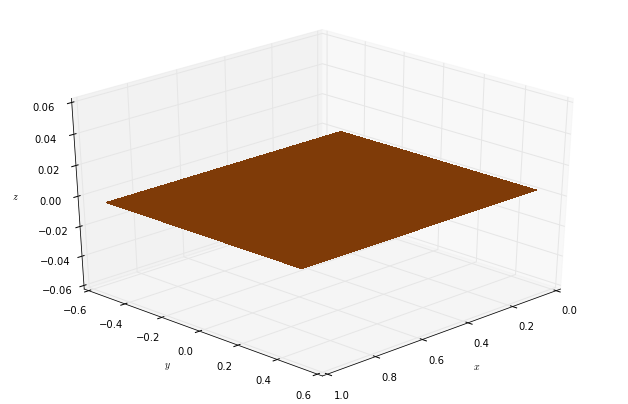

In [6]:
X, Y, x, y, p_i, b, dx, dy, L = initialization(nx, ny, xmax, xmin, ymax, ymin)
plot2D(x, y, p_i)

That looks suitably boring.  Zeros everywhere and boundaries held at zero.  If this were a Laplace problem we would already be done!  

We are ready to advance the initial guess in pseudo-time and see what effect the forcing function has on `p`.

In [7]:
p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

Number of Jacobi iterations: 5587


Let's take a look:

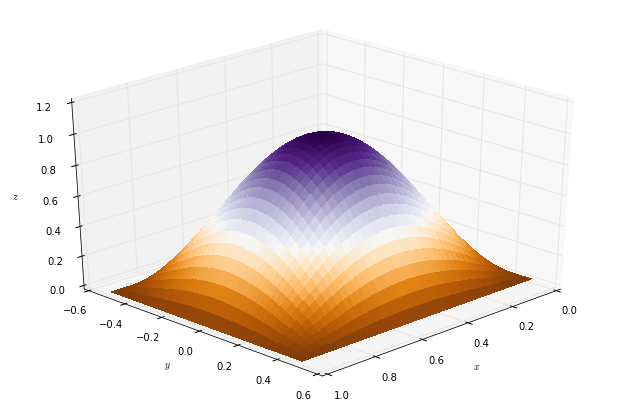

In [8]:
plot2D(x,y,p)

Something has definitely happened.  That looks good, but what about the error? This problem has the following analytical solution:

\begin{equation}
p(x,y) = y(1-y)x^3
\end{equation}

Time to compare the calculated solution to the analytical.  

In [9]:
def p_analytical(X,Y,L):
    ''' Computes analytical solution to Poisson problem
    Parameters:
    ----------
    X: 2D array of float
        Mesh with x components
    Y: 2D array of float
        Mesh with y components
    L: float
        Size of domain
    Returns:
    -------
    Analytical solution
    '''
    return numpy.sin(X*pi/L)*numpy.cos(Y*pi/L)

In [10]:
p_an = p_analytical(X,Y,L)

In [11]:
error = L2_rel_error(p,p_an)
error

0.00051416820220737678

That is not bad!

#####How did `l2_norm` evolve with each iteration? 

Remember that we saved the `l2_norm` at each iteration in the `poisson2D` function?  Now we can look at how it evolved over the course of the problem.

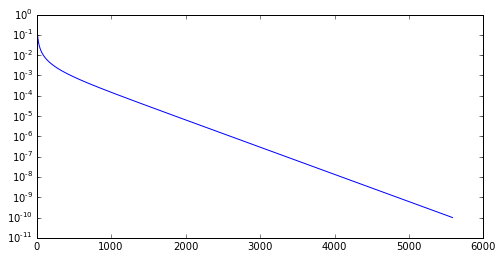

In [12]:
pyplot.figure(figsize=(8,4))
pyplot.semilogy(numpy.arange(len(l2_conv)), l2_conv);

In the beginning, iterations were converging at a pretty fast rate, but then they kind of stalled out. Are there better ways of doing this? We'll look at that in the following notebooks!

### Convergence

For a sanity check, let's make sure the code is converging as expected

In [13]:
nx_values = numpy.asarray([11,21,41,81])
ny_values = numpy.asarray([11,21,41,81])

error = numpy.zeros(len(nx_values))

for i in range(len(nx_values)):
    
    nx = nx_values[i]
    ny = ny_values[i]
    
    X, Y, c, y, p_i, b, dx, dy, L = initialization(nx, ny, xmax, xmin, ymax, ymin)
    p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

    p_an = p_analytical(X,Y,L)
    
    error[i] = L2_rel_error(p,p_an)

Number of Jacobi iterations: 400
Number of Jacobi iterations: 1505
Number of Jacobi iterations: 5587
Number of Jacobi iterations: 20563


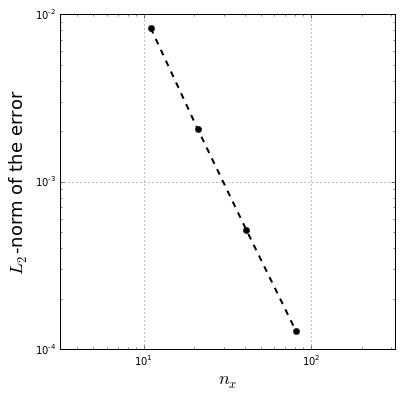

In [14]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

That looks pretty much second order!  Remember that the boundary conditions can adversely effect convergence, but Dirichlet boundaries are "exact" and will never impact your convergence.  

***

In [15]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())